In [20]:
import json

from openai import OpenAI

from dotenv import load_dotenv
from datetime import datetime, timedelta

load_dotenv()

True

### 1. Prompting Basics

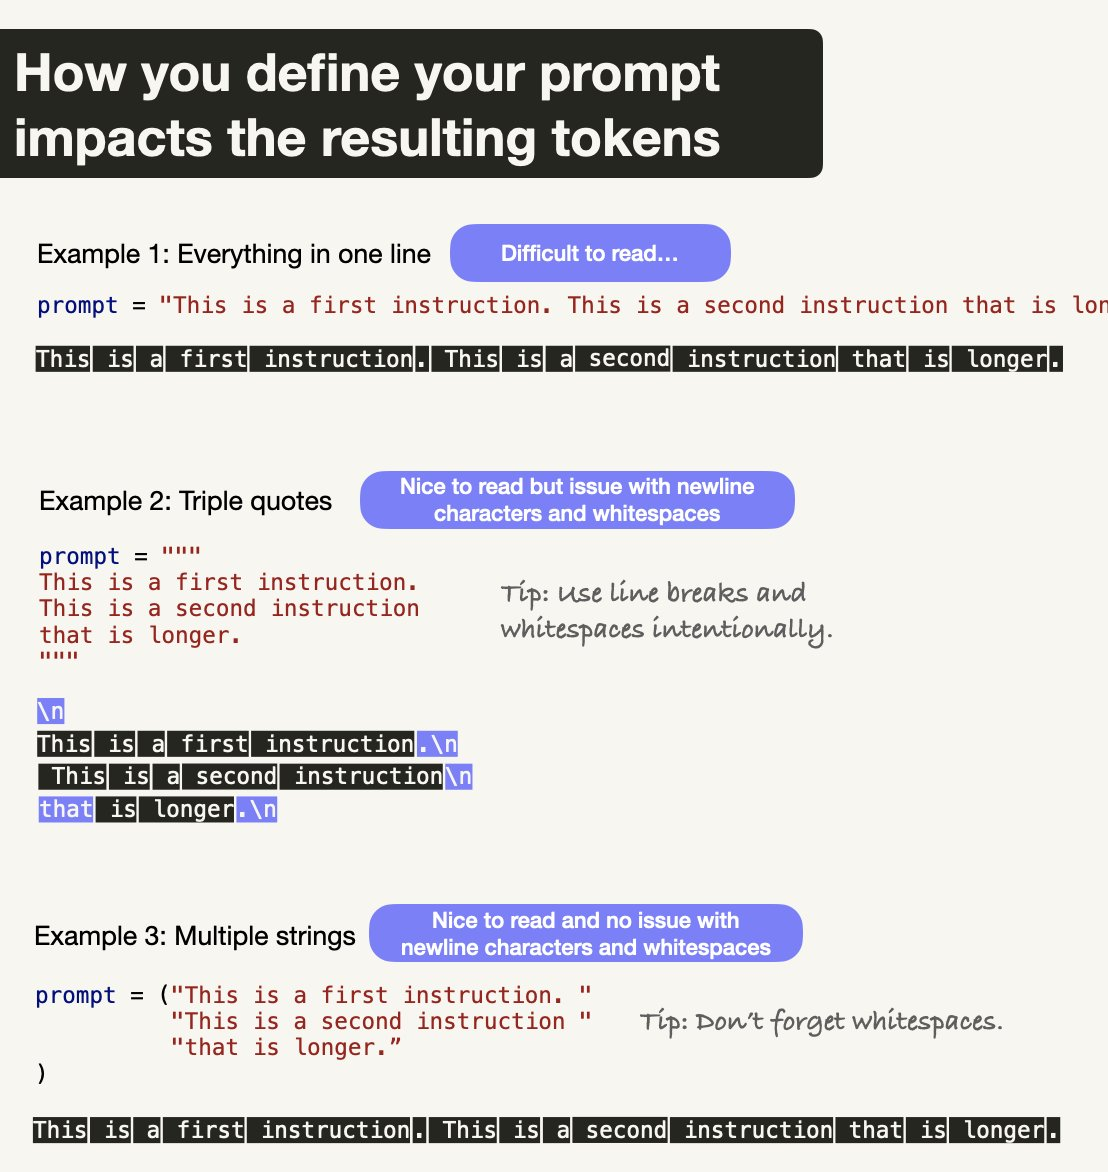

In [6]:
student_description = """
Anubrata Bhowmick is a student of Computer Science with Data Science specialization at the University of Twente. He is Indian and has a 8.15 GPA. He is popular for his programming skills and is an active member at Inter-Actief, the CS club of the university. He wants to pursue a career in Generative AI after his graduation.
"""

In [7]:
student_description

'\nAnubrata Bhowmick is a student of Computer Science with Data Science specialization at the University of Twente. He is Indian and has a 8.15 GPA. He is popular for his programming skills and is an active member at Inter-Actief, the CS club of the university. He wants to pursue a career in Generative AI after his graduation.\n'

In [8]:
# A simple prompt to extract information from "student_description" in a JSON format
prompt = f'''
Please extract the following information from the given text and return it as a JSON object:

Name
College
Grades
Club

This is the body of the text to extract the information from: {student_description}
'''

In [3]:
client = OpenAI()
client

In [14]:
response = client.chat.completions.create(
    model = "gpt-4o",
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ]
)

In [31]:
output = response.choices[0].message.content

# Remove Markdown code block delimiters and surrounding whitespace
cleaned_output = output.strip('```json\n')
cleaned_output

'```json\n{\n  "Name": "Anubrata Bhowmick",\n  "College": "University of Twente",\n  "Grades": "8.15 GPA",\n  "Club": "Inter-Actief"\n}\n```'

In [33]:
json.loads(cleaned_output)

{'Name': 'Anubrata Bhowmick',
 'College': 'University of Twente',
 'Grades': '8.15 GPA',
 'Club': 'Inter-Actief'}

### 2. Function Calling

In [57]:
student_custom_function = [
    {
        'name': 'extract_student_info',
        'description': 'Get the student information from the body of the input text',
        'parameters': {
            'type': 'object',
            'properties': {
                'name': {
                    'type': 'string',
                    'description': 'Name of the person'
                },
                'college': {
                    'type': 'string',
                    'description': 'College Name'
                },
                'grades':{
                    'type': 'number',
                    'description': 'CGPA of the student'
                },
                'club': {
                    'type': 'string',
                    'description': 'College club for extracurricular activities'
                }
            }
        }
    }
]

In [35]:
func_response = client.chat.completions.create(
    model = "gpt-4o",
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ],
    functions=student_custom_function
)

In [51]:
# Make sure to check the responses in each level
func_response.choices[0].message.function_call.arguments

'{"name":"Anubrata Bhowmick","college":"University of Twente","grades":8,"club":"Inter-Actief"}'

In [52]:
func_output = func_response.choices[0].message.function_call.arguments

In [53]:
json.loads(func_output)

{'name': 'Anubrata Bhowmick',
 'college': 'University of Twente',
 'grades': 8,
 'club': 'Inter-Actief'}

### 3. Benefits of function calling

In [50]:
student_description_two = """
Gabriela Mitrana is a student of Interaction Technology with Data Science specialization at the University of Twente. She is Romanian and has a 7.5 GPA. She is popular for her analytical skills and is an active member at IntUit, the Interaction Technology club of the university. She wants to pursue a career in Business Studies after her graduation.
"""

In [58]:
student_info = [student_description, student_description_two]

for student in student_info:
    func_response_loop = client.chat.completions.create(
        model = "gpt-4o",
        messages=[
            {
                "role": "user",
                "content": student
            }
        ],
        functions=student_custom_function,
        function_call='auto'
    )
    print(json.loads(func_response_loop.choices[0].message.function_call.arguments))

{'name': 'Anubrata Bhowmick', 'college': 'University of Twente', 'grades': 8.15, 'club': 'Inter-Actief'}
{'name': 'Gabriela Mitrana', 'college': 'University of Twente', 'grades': 7.5, 'club': 'IntUit'}


In [59]:
student_custom_function_two = [
    {
        'name': 'extract_student_ambition',
        'description': 'Get the student ambition from the body of the input text',
        'parameters': {
            'type': 'object',
            'properties': {
                'career': {
                    'type': 'string',
                    'description': 'Career ambition after graduation'
                }
            }
        }
    }
]

In [66]:
student_info = [student_description, student_description_two]
multiple_functions = [student_custom_function[0], student_custom_function_two[0]]

for student in student_info:
    for func in multiple_functions:
        mul_func_response_loop = client.chat.completions.create(
            model = "gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": student
                }
            ],
            functions=[func],
            function_call='auto'
        )
        print(json.loads(mul_func_response_loop.choices[0].message.function_call.arguments))

{'name': 'Anubrata Bhowmick', 'college': 'University of Twente', 'grades': 8.15, 'club': 'Inter-Actief'}
{'career': 'He wants to pursue a career in Generative AI after his graduation.'}
{'name': 'Gabriela Mitrana', 'college': 'University of Twente', 'grades': 7.5, 'club': 'IntUit'}
{'career': 'She wants to pursue a career in Business Studies after her graduation.'}


### 4. Advanced Example of Functions

In [4]:
flight_resp_orig = client.chat.completions.create(
    model = "gpt-4o",
    messages=[
        {
            "role": "user",
            "content": "When's the next flight from Amsterdam to Bucharest?"
        }
    ],
)

In [10]:
flight_resp_orig.choices[0].message.content

"I don't have the ability to provide real-time information as my data was last updated in January 2022. For the most accurate and up-to-date information about flight schedules from Amsterdam to Bucharest, I recommend checking with airlines directly or using an online travel service like Expedia, Skyscanner, or the websites of the airports involved. You could also use a flight tracking app or website such as FlightAware or FlightRadar24 for the latest flight information."

In [11]:
advanced_function_desc = [
    {
        "name": "get_flight_info",
        "description": "Get flight information between two locations",
        "parameters": {
            "type": "object",
            "properties": {
                "loc_origin": {
                    "type": "string",
                    "description": "The departure airport, e.g. AMS"
                },
                "loc_destination": {
                    "type": "string",
                    "descrption": "The destination airport, e.g. IATA"
                },
            },
            "required": ["loc_origin", "loc_destination"]
        },
    }
]

In [12]:
user_prompt = "When's the next flight from Amsterdam to Bucharest?"

In [13]:
flight_resp_new = client.chat.completions.create(
    model = "gpt-4o",
    messages=[
        {
            "role": "user",
            "content": user_prompt
        }
    ],
    functions=advanced_function_desc,
    function_call='auto'
)

In [18]:
flight_resp_new.choices[0].message.function_call.arguments

'{"loc_origin":"AMS","loc_destination":"BUH"}'

In [21]:
# Let's create a mock API
def get_flight_info(loc_origin, loc_destination):
    """ Get flight info between two locations """
    
    flight_info = {
        "loc_origin": loc_origin,
        "loc_destination": loc_destination,
        "datetime": str(datetime.now() + timedelta(hours=2)),
        "airline": "KLM",
        "flight": "KLM641",
    }
    
    return json.dumps(flight_info)

In [22]:
location_from_prompts = json.loads(flight_resp_new.choices[0].message.function_call.arguments)
location_from_prompts

{'loc_origin': 'AMS', 'loc_destination': 'BUH'}

In [30]:
flight_resp_new.choices[0].message.function_call.name

'get_flight_info'

In [38]:
# Let's choose the function from the response to hit the api
chosen_func = eval(flight_resp_new.choices[0].message.function_call.name)
flight = chosen_func(location_from_prompts.get('loc_origin'), location_from_prompts.get('loc_destination'))

print(flight)

{"loc_origin": "AMS", "loc_destination": "BUH", "datetime": "2024-07-10 17:33:06.687709", "airline": "KLM", "flight": "KLM641"}


In [39]:
flight_resp_final = client.chat.completions.create(
    model = "gpt-4o",
    messages=[
        {
            "role": "user",
            "content": user_prompt
        },
        {
            "role": "function",
            "name": flight_resp_new.choices[0].message.function_call.name,
            "content": flight
        }
    ],
    functions=advanced_function_desc,
    function_call='auto'
)

In [47]:
flight_resp_final.choices[0].message.content

"The next flight from Amsterdam (AMS) to Bucharest (BUH) is operated by KLM. The flight number is KLM641. Please check the airline's website or contact their customer service for the exact departure time and any additional details."